# Gaussian Process Regression for Stellar Light Curves

*Tutorial by Yuan-Sen Ting (ting.74@osu.edu)*

*Companion material for Chapter 14 of the textbook*
  
*If you find this tutorial useful, please cite the accompanying textbook:*

*[Statistical Machine Learning for Astronomy](https://arxiv.org/abs/2506.12230)*

*© 2025 Yuan-Sen Ting. All rights reserved. This tutorial may be redistributed by sharing the original [GitHub repository link](https://github.com/tingyuansen/statml) for educational purposes. Any other reproduction or adaptation requires explicit permission from the author.*


## Introduction

In Chapter 14, we explored the mathematical foundations of Gaussian Processes, developing a framework that transforms our perspective from parametric function fitting to non-parametric function learning. We saw how the kernel trick enables us to work in potentially infinite-dimensional feature spaces while maintaining computational tractability, and how conditioning on observed data naturally provides both predictions and uncertainty quantification. These theoretical insights now require practical application to demonstrate their utility in astronomical data analysis.

This tutorial examines the analysis of stellar light curves through Gaussian Process regression. Stars reveal their internal structures through brightness variations captured by space-based photometry missions. These variations arise from acoustic oscillations propagating through stellar interiors and encode information about fundamental stellar properties including mass, radius, and evolutionary state. The challenge lies in extracting this information from quasi-periodic signals contaminated by instrumental noise and astrophysical variability.

Traditional approaches to stellar light curve analysis often rely on Fourier transforms to identify oscillation frequencies, followed by peak-fitting algorithms to extract mode parameters. While these methods have proven successful, they require careful tuning, struggle with irregular sampling, and provide limited uncertainty quantification. More fundamentally, they impose a specific functional form—sums of sinusoids—that may not capture the stochastic nature of stellar oscillations.

Gaussian Processes offer a different philosophy. Rather than decomposing the signal into predetermined basis functions, we encode our expectations about the statistical properties of stellar variability through kernel functions. The observed data then determines the specific realization of these properties, automatically adapting to each star's unique oscillation pattern. This approach proves particularly useful when we recognize that we often care more about characteristic timescales than detailed mode identification—a natural strength of kernel-based methods.

## Prerequisites and Learning Objectives

### Foundational Knowledge

This tutorial assumes familiarity with:
- **Python Programming**: Comfort with NumPy arrays, matplotlib visualization, and basic scipy functionality
- **Gaussian Process Theory**: Understanding of kernel functions, marginal likelihood, and GP regression as covered in Chapter 14
- **Time Series Concepts**: Basic knowledge of sampling rates, Nyquist frequency, and temporal data analysis
- **Astronomical Context**: Elementary understanding of stellar evolution and photometric observations

### Learning Outcomes

Through this tutorial, you will develop practical skills in:
- **Kernel Selection for Physical Systems**: Choosing appropriate kernel functions that encode domain knowledge about stellar oscillations
- **Hyperparameter Optimization**: Implementing efficient strategies for learning kernel parameters through marginal likelihood maximization
- **Computational Efficiency**: Managing the $O(N^3)$ complexity of GP inference through strategic subsampling and optimization techniques
- **Physical Interpretation**: Connecting GP hyperparameters to meaningful stellar properties
- **Uncertainty Quantification**: Understanding how GP predictions naturally provide confidence intervals for derived parameters

We begin by importing the necessary libraries and configuring our computational environment:


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.optimize import minimize
from tqdm import tqdm

# Configure plotting parameters for publication-quality figures
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

# Set random seed for reproducibility
np.random.seed(42)

%matplotlib inline

## The Kepler Stellar Light Curve Dataset

For this tutorial, we work with a curated subset of 100 stellar light curves from the Kepler space telescope. Each light curve consists of normalized brightness measurements taken at 30-minute intervals over approximately 90 days. The dataset includes stars spanning a range of evolutionary states, with surface gravities (log g) serving as our target labels.

Surface gravity provides a fundamental stellar parameter that correlates with oscillation timescales—evolved stars with lower surface gravities exhibit longer-period oscillations than compact main-sequence stars. This physical relationship makes the dataset ideal for exploring how Gaussian Processes can extract meaningful parameters from complex time series data.

Let's load and explore the dataset structure:

The shape of the dataset is:  (100, 4365)


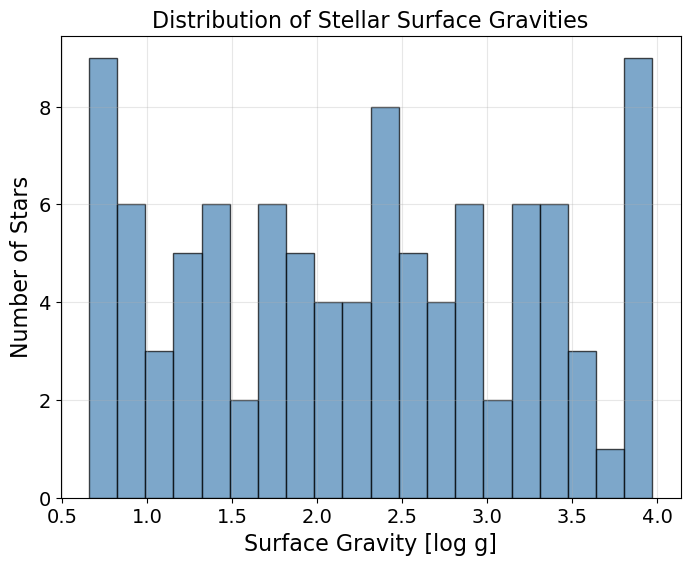

In [2]:
# Load the dataset
temp = np.load('dataset_stellar_light_curves.npz')
light_curve = temp['data']
label = temp['label']

# Time array in minutes, adjacent data points are 30 minutes apart
time = np.arange(0, 30*light_curve.shape[1], 30)

# Print the shape of the dataset
print("The shape of the dataset is: ", light_curve.shape)

# Display a histogram of the labels
plt.figure(figsize=(8, 6))
plt.hist(label, bins=20, alpha=0.7, color='steelblue', edgecolor='black')
plt.xlabel('Surface Gravity [log g]')
plt.ylabel('Number of Stars')
plt.title('Distribution of Stellar Surface Gravities')
plt.grid(True, alpha=0.3)
plt.show()

## Visualizing Stellar Oscillation Patterns

To understand the relationship between surface gravity and oscillation timescales, let's examine representative light curves across our sample. By ordering stars by their surface gravity values, we can observe how oscillation patterns systematically change with stellar evolution. This visualization will motivate our choice of Gaussian Process kernels and help us understand what information the GP hyperparameters should capture.

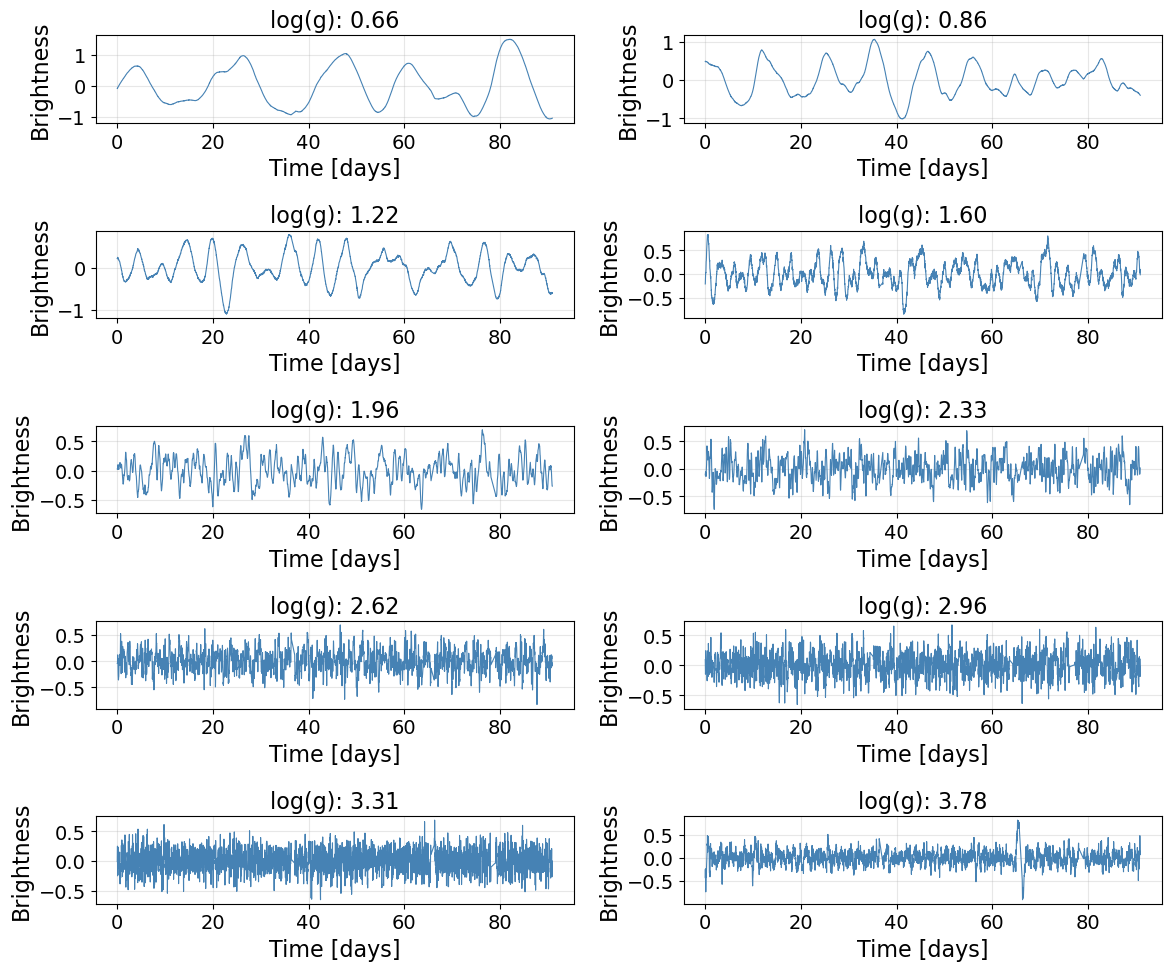

In [3]:
# Sort the light curves by their log(g) label for clarity in visualization
idx = np.argsort(label)
label_sorted = label[idx]
light_curve_sorted = light_curve[idx]

# Initialize the figure
plt.figure(figsize=(12, 10))

# Plot 10 representative light curves, ranging from low to high log(g) values
for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.plot(time/60/24, light_curve_sorted[i*10], linewidth=0.8, color='steelblue')
    plt.xlabel('Time [days]')
    plt.ylabel('Brightness')
    plt.title('log(g): {:.2f}'.format(label_sorted[i*10]))
    plt.grid(True, alpha=0.3)

# Ensure the subplots are well spaced to avoid overlap
plt.tight_layout()
plt.show()

The visualization reveals a clear systematic pattern: stars with lower surface gravity (top panels) exhibit longer oscillation periods compared to those with higher surface gravity (bottom panels). This relationship emerges from fundamental stellar structure—as stars evolve and expand, their acoustic cavities grow larger, leading to slower oscillations. The stochastic nature of these variations, with amplitudes and phases that evolve over time, makes them ideal candidates for Gaussian Process modeling.

For our analysis, we'll focus on a single light curve to develop and validate our GP methodology:

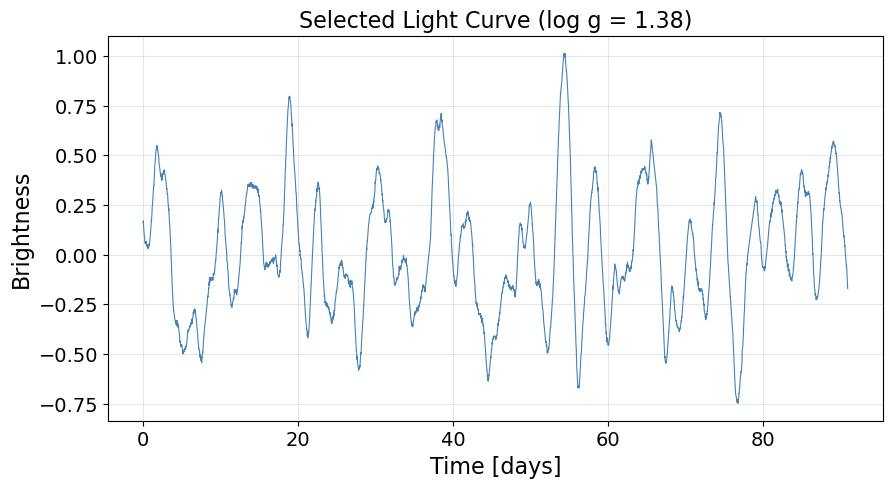

In [4]:
# Selecting a light curve for in-depth exploration
selected_light_curve = light_curve[50]

# Visualizing the chosen light curve
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(time/60/24, selected_light_curve, linewidth=0.8, color='steelblue')
ax.set_xlabel("Time [days]")
ax.set_ylabel("Brightness")
ax.set_title(f"Selected Light Curve (log g = {label[50]:.2f})")
ax.grid(True, alpha=0.3)
plt.show()

## Gaussian Process Modeling of Stellar Light Curves

A key strength of Gaussian Processes lies in their ability to simultaneously model the underlying signal and characterize the noise. For stellar oscillations, the Radial Basis Function (RBF) kernel provides a natural starting point. This kernel encodes our expectation of smooth, continuous variations in stellar brightness:

$$k(t, t') = \sigma_f^2 \exp\left(-\frac{(t - t')^2}{2l^2}\right)$$

where $\sigma_f^2$ controls the amplitude of variations and $l$ sets the characteristic timescale. For our analysis, we'll fix $\sigma_f^2 = 1$ and focus on learning the timescale $l$, as we're primarily interested in oscillation periods rather than absolute amplitudes.

In the full GP framework, we model observations as:

$$y_i = f(t_i) + \epsilon_i, \quad \epsilon_i \sim \mathcal{N}(0, \sigma_n^2)$$

where $f(t)$ represents the latent stellar variability and $\sigma_n^2$ characterizes the observation noise variance. By treating both $l$ and $\sigma_n^2$ as hyperparameters, we let the data inform us about both the intrinsic timescales and the noise level.

## Building Intuition: From 2D Gaussians to GP Regression

Before applying Gaussian Processes to stellar light curves, let's develop intuition through simpler examples. We'll start with 2D Gaussian distributions to understand key concepts like conditioning and maximum likelihood estimation, then progress to 1D function regression. This progression mirrors the conceptual leap from finite-dimensional to infinite-dimensional Gaussian distributions that underlies GP theory.

Consider a set of points in 2D space following a bivariate Gaussian distribution. This scenario directly parallels GP regression: we have a joint Gaussian distribution over multiple variables, and we condition on observed values to make predictions about unobserved ones. The mathematical machinery is identical—only the dimensionality differs.

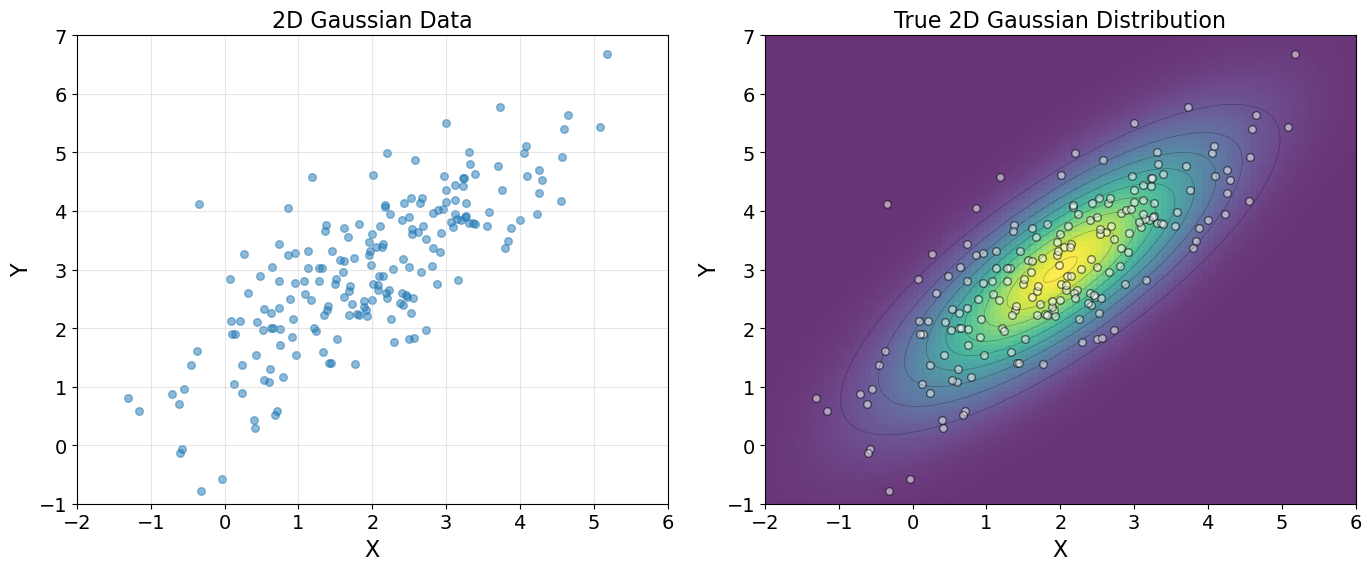

In [5]:
# Generate 2D Gaussian data
np.random.seed(42)
n_points = 200

# True parameters of our 2D Gaussian
true_mean = np.array([2.0, 3.0])
true_cov = np.array([[2.0, 1.5], 
                     [1.5, 1.8]])

# Generate samples
data_2d = np.random.multivariate_normal(true_mean, true_cov, n_points)

# Visualize the data and true distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot
ax1.scatter(data_2d[:, 0], data_2d[:, 1], alpha=0.5, s=30)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_xlim(-2, 6)
ax1.set_ylim(-1, 7)
ax1.set_title('2D Gaussian Data')
ax1.grid(True, alpha=0.3)

# For the contour plot, use imshow for full coverage
x = np.linspace(-2, 6, 100)
y = np.linspace(-1, 7, 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

from scipy.stats import multivariate_normal
rv = multivariate_normal(true_mean, true_cov)
Z = rv.pdf(pos)

# Use imshow for complete fill
im = ax2.imshow(Z.T, origin='lower', extent=[-2, 6, -1, 7], 
                cmap='viridis', alpha=0.8, aspect='auto')

# Add contour lines on top
ax2.contour(X, Y, Z, levels=10, colors='k', alpha=0.3, linewidths=0.5)

ax2.scatter(data_2d[:, 0], data_2d[:, 1], alpha=0.5, s=30, c='white', edgecolor='black')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_xlim(-2, 6)
ax2.set_ylim(-1, 7)
ax2.set_title('True 2D Gaussian Distribution')

plt.tight_layout()
plt.show()

### Maximum Likelihood Estimation for 2D Gaussians

Now let's estimate the parameters of this 2D Gaussian from our data using maximum likelihood estimation. This process directly parallels how we'll later optimize hyperparameters in our GP model. For a multivariate Gaussian, the maximum likelihood estimates have closed-form solutions:

- Mean: $\hat{\boldsymbol{\mu}} = \frac{1}{n}\sum_{i=1}^n \mathbf{x}_i$
- Covariance: $\hat{\boldsymbol{\Sigma}} = \frac{1}{n}\sum_{i=1}^n (\mathbf{x}_i - \hat{\boldsymbol{\mu}})(\mathbf{x}_i - \hat{\boldsymbol{\mu}})^T$

These estimators emerge from maximizing the log-likelihood:

$$\log \mathcal{L}(\boldsymbol{\mu}, \boldsymbol{\Sigma}) = -\frac{n}{2}\log(2\pi) - \frac{n}{2}\log|\boldsymbol{\Sigma}| - \frac{1}{2}\sum_{i=1}^n (\mathbf{x}_i - \boldsymbol{\mu})^T\boldsymbol{\Sigma}^{-1}(\mathbf{x}_i - \boldsymbol{\mu})$$

True mean: [2. 3.]
ML estimated mean: [1.9747804  3.00983086]

True covariance:
[[2.  1.5]
 [1.5 1.8]]

ML estimated covariance:
[[1.80706528 1.37537294]
 [1.37537294 1.68442191]]


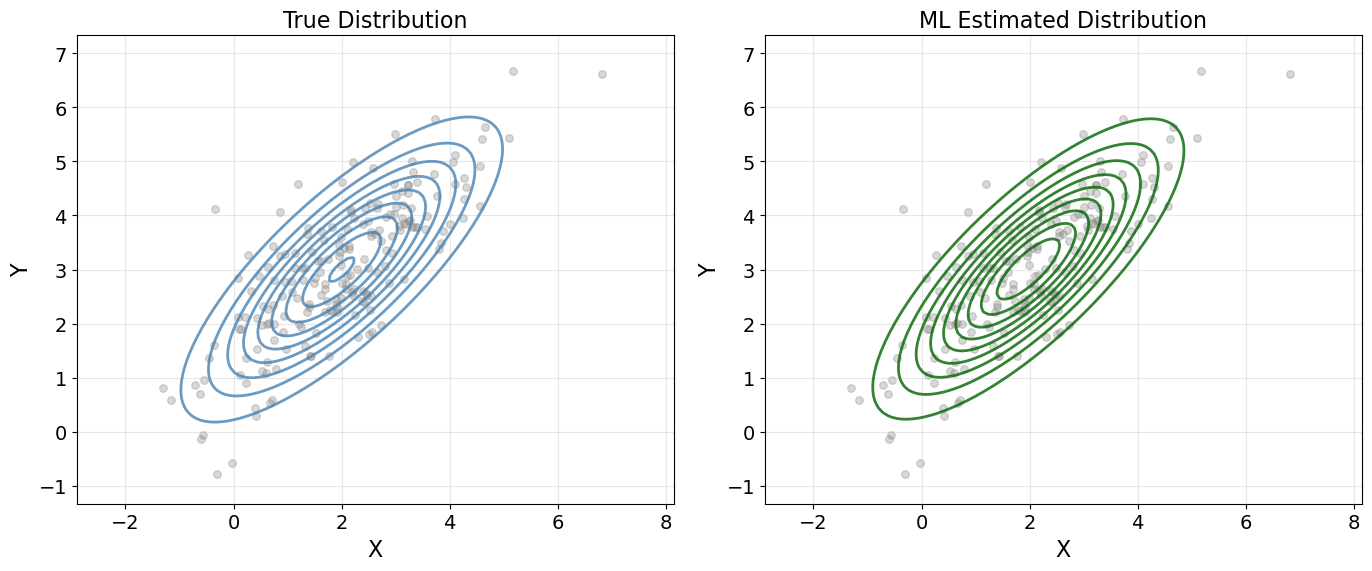

In [6]:
# Maximum likelihood estimation
ml_mean = np.mean(data_2d, axis=0)
ml_cov = np.cov(data_2d.T)

# Compare true and estimated parameters
print("True mean:", true_mean)
print("ML estimated mean:", ml_mean)
print("\nTrue covariance:")
print(true_cov)
print("\nML estimated covariance:")
print(ml_cov)

# Visualize the comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot data with true distribution
rv_true = multivariate_normal(true_mean, true_cov)
ax1.contour(X, Y, rv_true.pdf(pos), levels=10, colors='steelblue', alpha=0.8, linewidths=2)
ax1.scatter(data_2d[:, 0], data_2d[:, 1], alpha=0.3, s=30, color='gray')
ax1.set_title('True Distribution')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.grid(True, alpha=0.3)
ax1.axis('equal')

# Plot data with ML estimated distribution
rv_ml = multivariate_normal(ml_mean, ml_cov)
ax2.contour(X, Y, rv_ml.pdf(pos), levels=10, colors='darkgreen', alpha=0.8, linewidths=2)
ax2.scatter(data_2d[:, 0], data_2d[:, 1], alpha=0.3, s=30, color='gray')
ax2.set_title('ML Estimated Distribution')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.grid(True, alpha=0.3)
ax2.axis('equal')

plt.tight_layout()
plt.show()

### Conditional Distributions: From Joint to Predictive

A fundamental property of multivariate Gaussians is that conditional distributions remain Gaussian. This property underlies GP regression: when we condition on observed data points, the distribution over unobserved points remains Gaussian. Let's explore this by examining $p(y|x)$—the conditional distribution of $y$ given a specific value of $x$.

For a bivariate Gaussian with parameters $\boldsymbol{\mu} = [\mu_x, \mu_y]^T$ and covariance matrix:

$$\boldsymbol{\Sigma} = \begin{bmatrix} \sigma_x^2 & \sigma_{xy} \\ \sigma_{xy} & \sigma_y^2 \end{bmatrix}$$

The conditional distribution $p(y|x)$ is:

$$p(y|x) = \mathcal{N}\left(\mu_y + \frac{\sigma_{xy}}{\sigma_x^2}(x - \mu_x), \sigma_y^2 - \frac{\sigma_{xy}^2}{\sigma_x^2}\right)$$

This formula reveals how observing $x$ updates our belief about $y$. The conditional mean shifts linearly with $(x - \mu_x)$, while the conditional variance is always smaller than the marginal variance—observing $x$ reduces our uncertainty about $y$ when they are correlated.

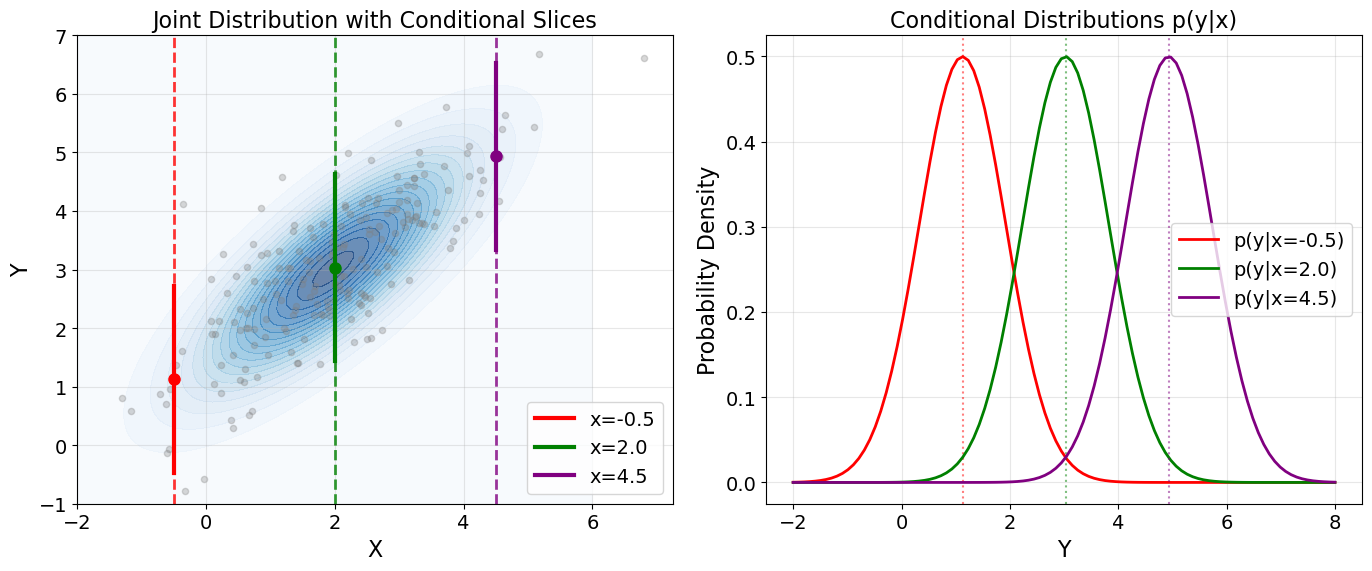

In [7]:
# Demonstrate conditional distributions p(y|x)
def conditional_gaussian(x_obs, mu, cov):
    """
    Compute conditional distribution p(y|x) for 2D Gaussian
    
    Parameters:
    -----------
    x_obs : float
        Observed x value
    mu : array
        Mean vector [mu_x, mu_y]
    cov : array
        2x2 covariance matrix
        
    Returns:
    --------
    cond_mean : float
        Conditional mean of y given x
    cond_var : float
        Conditional variance of y given x
    """
    mu_x, mu_y = mu
    var_x = cov[0, 0]
    var_y = cov[1, 1]
    cov_xy = cov[0, 1]
    
    cond_mean = mu_y + (cov_xy / var_x) * (x_obs - mu_x)
    cond_var = var_y - (cov_xy**2 / var_x)
    
    return cond_mean, cond_var

# Visualize conditional distributions for different x values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: Joint distribution with conditioning lines
ax1.contourf(X, Y, rv_ml.pdf(pos), levels=20, cmap='Blues', alpha=0.6)
ax1.scatter(data_2d[:, 0], data_2d[:, 1], alpha=0.3, s=20, c='gray')

# Show three different x values
x_conditions = [-0.5, 2.0, 4.5]
colors = ['red', 'green', 'purple']
y_range = np.linspace(-2, 8, 100)

for x_cond, color in zip(x_conditions, colors):
    # Vertical line at x = x_cond
    ax1.axvline(x_cond, color=color, linestyle='--', alpha=0.8, linewidth=2)
    
    # Compute and plot conditional distribution
    cond_mean, cond_var = conditional_gaussian(x_cond, ml_mean, ml_cov)
    cond_std = np.sqrt(cond_var)
    
    # Plot conditional mean and ±2σ bands
    ax1.plot([x_cond, x_cond], [cond_mean - 2*cond_std, cond_mean + 2*cond_std], 
             color=color, linewidth=3, label=f'x={x_cond:.1f}')
    ax1.plot(x_cond, cond_mean, 'o', color=color, markersize=8)

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('Joint Distribution with Conditional Slices')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right plot: Conditional distributions p(y|x)
for x_cond, color in zip(x_conditions, colors):
    cond_mean, cond_var = conditional_gaussian(x_cond, ml_mean, ml_cov)
    cond_dist = stats.norm(cond_mean, np.sqrt(cond_var))
    
    ax2.plot(y_range, cond_dist.pdf(y_range), color=color, linewidth=2, 
             label=f'p(y|x={x_cond:.1f})')
    ax2.axvline(cond_mean, color=color, linestyle=':', alpha=0.5)

ax2.set_xlabel('Y')
ax2.set_ylabel('Probability Density')
ax2.set_title('Conditional Distributions p(y|x)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Connecting 2D Gaussians to Gaussian Processes

This 2D example illuminates the mechanics of Gaussian Process regression. In GP regression, we have a joint Gaussian distribution over function values at all time points. When we observe the function at certain times (our training data), we condition on these observations to predict values at new times—exactly analogous to computing $p(y|x)$ in our 2D case.

The key insights from our 2D analysis that transfer to GP regression are:

1. **Conditioning reduces uncertainty**: The conditional variance is always smaller than the marginal variance, reflecting how observations constrain our predictions
2. **Correlation enables prediction**: The covariance term $\sigma_{xy}$ determines how strongly observations at one point influence predictions at another
3. **Maximum likelihood provides principled parameter estimation**: Just as we estimated the 2D Gaussian parameters, we'll optimize GP hyperparameters by maximizing marginal likelihood

Now let's bridge our 2D Gaussian example to the function regression setting. Instead of arbitrary $(x, y)$ pairs, consider the case where y represents function values $f(x)$ at different input locations. This transforms our problem into one of function interpolation—given observations of $f$ at some locations, predict its values elsewhere.

We'll generate data from a smooth function and add Gaussian noise, then use GP regression to recover the underlying function:

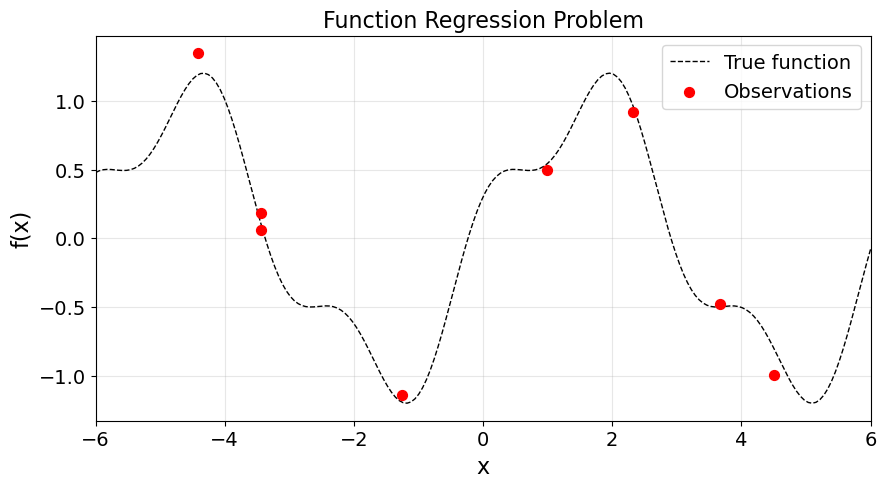

In [8]:
# Generate data from a smooth function with noise
np.random.seed(42)

# True underlying function
def true_function(x):
    return np.sin(x) + 0.3 * np.cos(3*x)

# Training data: observe function at specific points
n_train = 8
x_train = np.sort(np.random.uniform(-5, 5, n_train))
noise_std = 0.1
y_train = true_function(x_train) + np.random.normal(0, noise_std, n_train)

# Test points: where we want to predict
x_test = np.linspace(-6, 6, 200)

# Visualize the setup
plt.figure(figsize=(10, 5))
plt.plot(x_test, true_function(x_test), 'k--', linewidth=1, label='True function')
plt.scatter(x_train, y_train, c='red', s=50, zorder=5, label='Observations')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Function Regression Problem')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(-6, 6)
plt.show()

### Gaussian Process Regression: From Prior to Posterior

In Gaussian Process regression, we place a prior distribution over functions. This prior is completely specified by a mean function $m(\mathbf{x})$ and a covariance function (kernel) $k(\mathbf{x}, \mathbf{x}')$. The RBF kernel we introduced earlier encodes our belief that the function should be smooth—nearby points should have similar function values.

The connection to our 2D Gaussian example becomes clear when we consider the joint distribution over function values. Just as we had a joint Gaussian over $(x, y)$ pairs, in GP regression we have a joint Gaussian over function values at all locations. For simplicity, let's assume a zero mean function. The joint distribution over training and test function values is:

$$\begin{bmatrix} \mathbf{f} \\ \mathbf{f}_* \end{bmatrix} \sim \mathcal{N}\left(\mathbf{0}, \begin{bmatrix} \mathbf{K} & \mathbf{k}_* \\ \mathbf{k}_*^T & k_{**} \end{bmatrix}\right)$$

where $\mathbf{K}$ is the kernel matrix evaluated at training points, $\mathbf{k}_*$ contains kernel evaluations between test and training points, and $k_{**}$ is the kernel evaluated at the test point.

When we observe noisy target values $\mathbf{t} = \mathbf{f} + \boldsymbol{\epsilon}$ where $\boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{\Sigma}_n)$ with $\mathbf{\Sigma}_n = \sigma_n^2\mathbf{I}$ for i.i.d. noise, we condition on these observations to obtain the posterior distribution over $\mathbf{f}_*$. This is exactly analogous to computing $p(y|x)$ in our 2D example, but now in higher dimensions.

In [9]:
# Define the RBF kernel
def rbf(xa, xb, sigma=1):
    """
    RBF Kernel computation.
    
    Parameters:
    -----------
    xa, xb : array-like
        Input arrays of shape (n, 1) and (m, 1)
    sigma : float
        Kernel length scale parameter
    
    Returns:
    --------
    K : array
        Kernel matrix of shape (n, m)
    """
    sqdist = scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(-sqdist / (2 * sigma ** 2))

# GP Regression implementation for 1D function
def gp_regression_1d(x_train, y_train, x_test, length_scale, noise_std):
    """
    Perform GP regression with RBF kernel
    
    Returns:
    --------
    mean : array
        Posterior mean at test points
    std : array
        Posterior standard deviation at test points
    """
    # Reshape for kernel computation
    X_train = x_train.reshape(-1, 1)
    X_test = x_test.reshape(-1, 1)
    
    # Compute kernel matrices
    K_train = rbf(X_train, X_train, sigma=length_scale)
    K_test_train = rbf(X_test, X_train, sigma=length_scale)
    K_test = rbf(X_test, X_test, sigma=length_scale)
    
    # Add noise to training covariance
    K_train_noise = K_train + noise_std**2 * np.eye(len(x_train))
    
    # Compute posterior mean and covariance
    L = np.linalg.cholesky(K_train_noise)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))
    
    mean = K_test_train @ alpha
    v = np.linalg.solve(L, K_test_train.T)
    cov = K_test - v.T @ v
    std = np.sqrt(np.diag(cov) + noise_std**2)  # Include noise in predictive variance
    
    return mean, std

The posterior distribution is Gaussian with:
- Mean: $m_* = m(\mathbf{x}_*) + \mathbf{k}_*^T (\mathbf{K} + \mathbf{\Sigma}_n)^{-1} (\mathbf{t} - \mathbf{m})$
- Variance: $\sigma_*^2 = k(\mathbf{x}_*, \mathbf{x}_*) - \mathbf{k}_*^T (\mathbf{K} + \mathbf{\Sigma}_n)^{-1} \mathbf{k}_*$

where $\mathbf{t}$ represents the observed target values, $\mathbf{m}$ is the prior mean function evaluated at training points, and $\mathbf{\Sigma}_n$ is the noise covariance matrix (often diagonal: $\mathbf{\Sigma}_n = \sigma_n^2\mathbf{I}$).

In the implementation above, we use the Cholesky decomposition for numerical stability and efficiency. Rather than directly inverting $\mathbf{K} + \mathbf{\Sigma}_n$, we decompose it as $\mathbf{L}\mathbf{L}^T$ where $\mathbf{L}$ is lower triangular. This allows us to solve linear systems through forward and backward substitution, which is both faster and more numerically stable than matrix inversion. The computation $(\mathbf{K} + \mathbf{\Sigma}_n)^{-1}(\mathbf{t} - \mathbf{m})$ becomes solving $\mathbf{L}\mathbf{L}^T\boldsymbol{\alpha} = \mathbf{t} - \mathbf{m}$ for $\boldsymbol{\alpha}$, which we do in two steps: first solve $\mathbf{L}\mathbf{v} = \mathbf{t} - \mathbf{m}$ for $\mathbf{v}$, then solve $\mathbf{L}^T\boldsymbol{\alpha} = \mathbf{v}$ for $\boldsymbol{\alpha}$.

The length scale parameter $l$ in the RBF kernel fundamentally controls the behavior of our GP regression. It determines how quickly the correlation between function values decays with distance. A small length scale means the function can vary rapidly, while a large length scale enforces smoother variations. Let's visualize this effect:

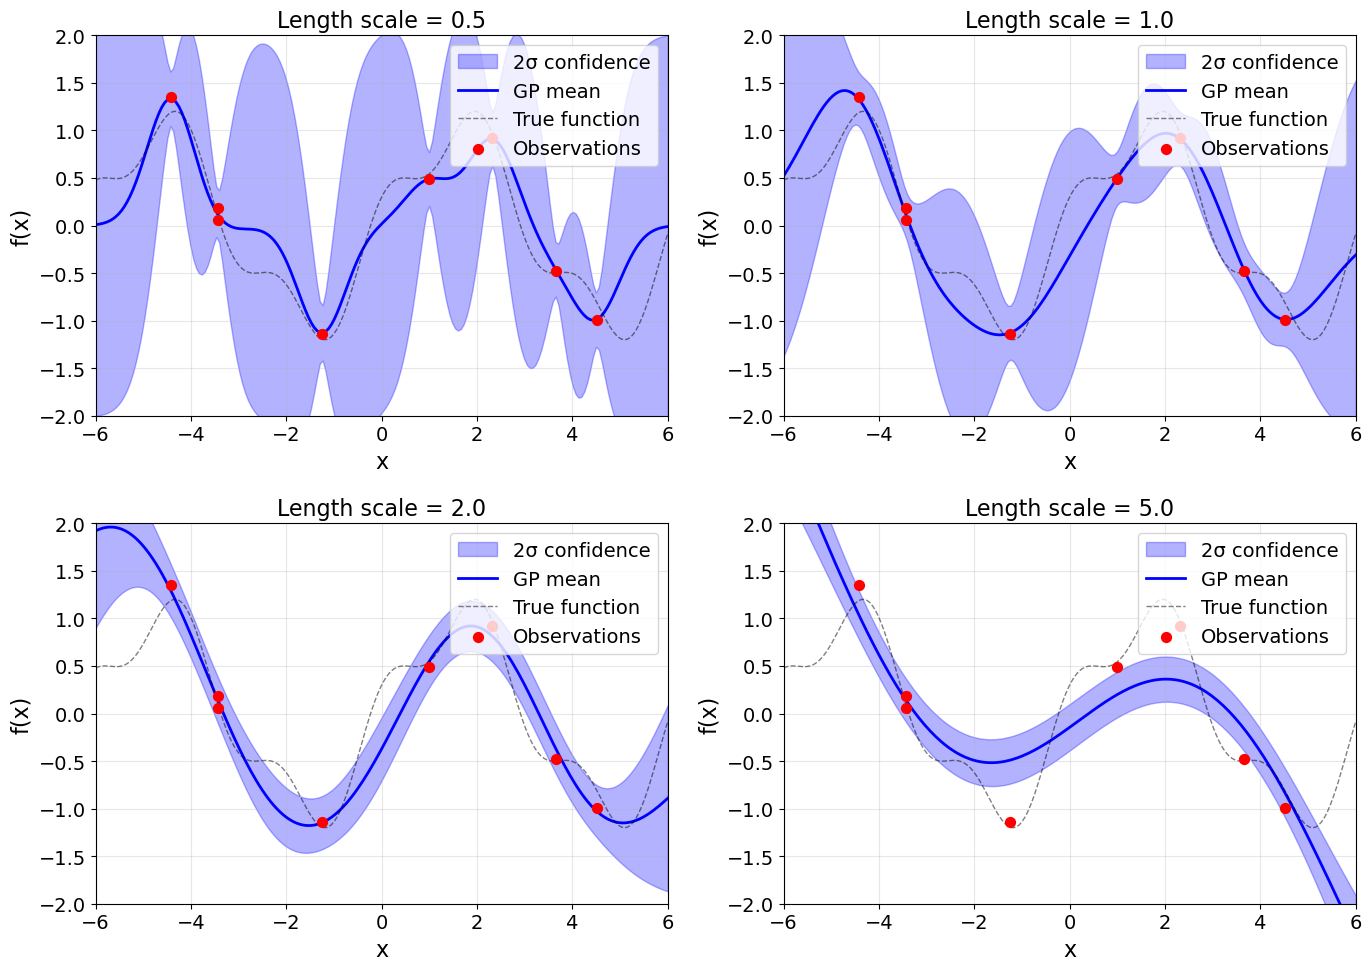

In [10]:
# Compute GP posterior with different length scales
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
length_scales = [0.5, 1.0, 2.0, 5.0]

for ax, ls in zip(axes.flat, length_scales):
    mean, std = gp_regression_1d(x_train, y_train, x_test, ls, noise_std)
    
    # Plot the results
    ax.fill_between(x_test, mean - 2*std, mean + 2*std, 
                    alpha=0.3, color='blue', label='2σ confidence')
    ax.plot(x_test, mean, 'b-', linewidth=2, label='GP mean')
    ax.plot(x_test, true_function(x_test), 'k--', linewidth=1, 
            label='True function', alpha=0.5)
    ax.scatter(x_train, y_train, c='red', s=50, zorder=5, label='Observations')
    
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')
    ax.set_title(f'Length scale = {ls}')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-6, 6)
    ax.set_ylim(-2, 2)

plt.tight_layout()
plt.show()

The visualization reveals how the length scale parameter fundamentally controls the behavior of our GP regression:

- **Small length scale (0.5)**: The function can vary rapidly, leading to wiggly interpolations that closely follow the data points. The uncertainty bands are narrow near observations but quickly expand between them.

- **Moderate length scale (1.0-2.0)**: The function exhibits smoother variations, balancing flexibility with regularity. These values often provide good interpolation for many real-world functions.

- **Large length scale (5.0)**: The function is constrained to be very smooth, essentially performing linear-like interpolation across the domain. While this prevents overfitting, it may underfit complex patterns.

Notice how uncertainty always collapses at observed points (up to observation noise) and grows in regions far from data—exactly as we saw in the conditional distributions of our 2D Gaussian example.

### Optimizing the Length Scale via Maximum Likelihood

Rather than manually selecting the length scale, we can use the same maximum likelihood principle from our 2D Gaussian example. The marginal likelihood (integrating out the function values) for GP regression is:

$$p(\mathbf{t}|\mathbf{X}, l, \sigma_n) = \mathcal{N}(\mathbf{t}|\mathbf{0}, \mathbf{K} + \sigma_n^2\mathbf{I})$$

where the covariance matrix $\mathbf{K}$ depends on the length scale $l$. Taking the log and simplifying:

$$\log p(\mathbf{t}|\mathbf{X}, l, \sigma_n) = -\frac{1}{2}\mathbf{t}^T(\mathbf{K} + \sigma_n^2\mathbf{I})^{-1}\mathbf{t} - \frac{1}{2}\log|\mathbf{K} + \sigma_n^2\mathbf{I}| - \frac{n}{2}\log(2\pi)$$

This objective function balances two competing terms: the data fit term $-\frac{1}{2}\mathbf{t}^T(\mathbf{K} + \sigma_n^2\mathbf{I})^{-1}\mathbf{t}$ and the complexity penalty $-\frac{1}{2}\log|\mathbf{K} + \sigma_n^2\mathbf{I}|$. Shorter length scales allow the model to fit the data more closely but increase the determinant, penalizing overly complex models.

In [11]:
# Implement marginal likelihood for hyperparameter optimization
def gp_marginal_likelihood(params, x_train, y_train):
    """
    Compute negative log marginal likelihood for optimization
    
    Parameters:
    -----------
    params : array
        [log10(length_scale), log10(noise_std)]
    x_train : array
        Training inputs
    y_train : array
        Training targets
        
    Returns:
    --------
    neg_log_ml : float
        Negative log marginal likelihood
    """
    # Extract parameters (work in log10 space for numerical stability)
    length_scale = 10**params[0]
    noise_std = 10**params[1]
    
    # Reshape inputs
    X_train = x_train.reshape(-1, 1)
    n = len(x_train)
    
    # Compute kernel matrix with noise
    K = rbf(X_train, X_train, sigma=length_scale)
    K_noise = K + noise_std**2 * np.eye(n)
    
    # Compute log marginal likelihood using Cholesky decomposition
    try:
        L = np.linalg.cholesky(K_noise)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))
        
        # Log marginal likelihood
        log_ml = -0.5 * y_train @ alpha - np.sum(np.log(np.diag(L))) - 0.5 * n * np.log(2 * np.pi)
        
        return -log_ml  # Return negative for minimization
    except np.linalg.LinAlgError:
        # Return large value if Cholesky fails (matrix not positive definite)
        return 1e10

# Grid search to visualize the likelihood landscape
log10_ls_range = np.linspace(-0.5, 0.7, 50)
log10_noise_range = np.linspace(-1.5, -0.2, 50)
nlml_grid = np.zeros((len(log10_ls_range), len(log10_noise_range)))

for i, log10_ls in enumerate(log10_ls_range):
    for j, log10_noise in enumerate(log10_noise_range):
        nlml_grid[i, j] = gp_marginal_likelihood([log10_ls, log10_noise], x_train, y_train)

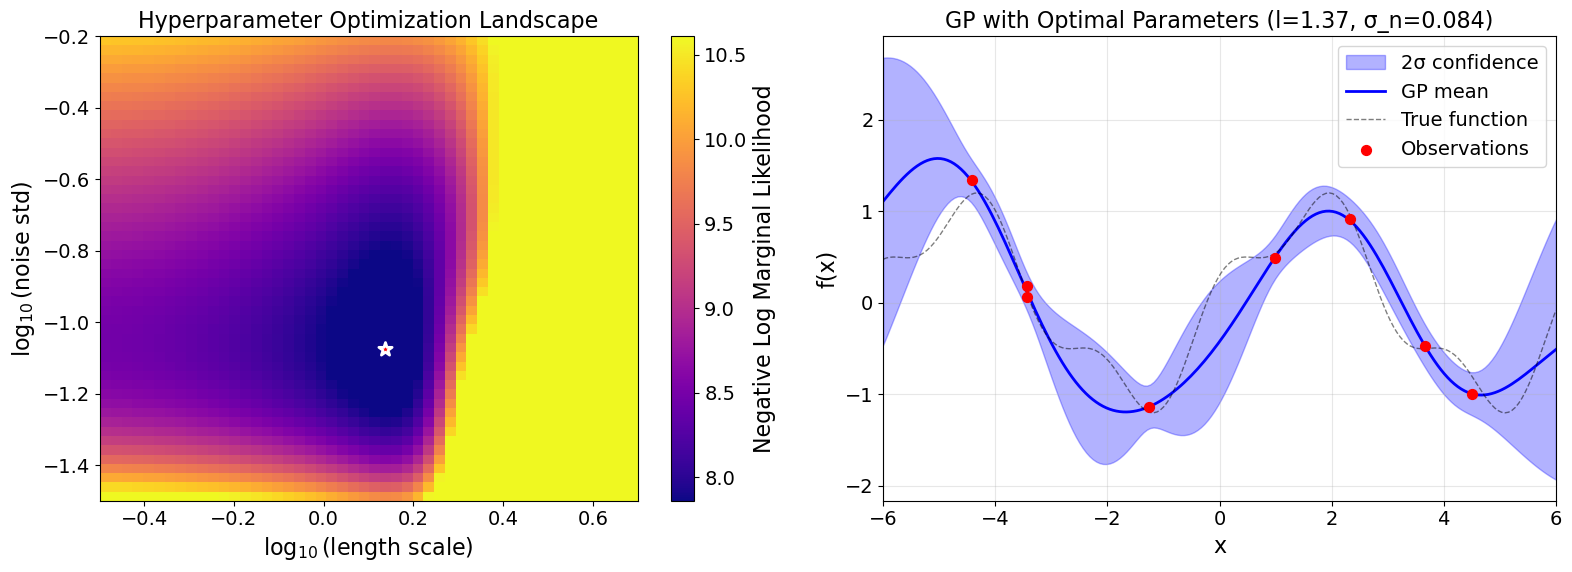

Optimal length scale: 1.370
Optimal noise std: 0.084
True noise std: 0.100


In [12]:
# Find optimal hyperparameters
min_idx = np.unravel_index(np.argmin(nlml_grid), nlml_grid.shape)
opt_log10_ls = log10_ls_range[min_idx[0]]
opt_log10_noise = log10_noise_range[min_idx[1]]
opt_ls = 10**opt_log10_ls
opt_noise = 10**opt_log10_noise

# Visualize the likelihood landscape
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Likelihood landscape with truncated colormap for better contrast
vmin = np.percentile(nlml_grid, 5)
vmax = np.percentile(nlml_grid, 70)
im1 = ax1.imshow(nlml_grid.T, origin='lower', aspect='auto', 
                 extent=[log10_ls_range[0], log10_ls_range[-1], 
                         log10_noise_range[0], log10_noise_range[-1]],
                 cmap='plasma', vmin=vmin, vmax=vmax)
ax1.scatter([opt_log10_ls], [opt_log10_noise], color='red', s=100, marker='*', 
            edgecolor='white', linewidth=2)
ax1.set_xlabel('$\log_{10}$(length scale)')
ax1.set_ylabel('$\log_{10}$(noise std)')
ax1.set_title('Hyperparameter Optimization Landscape')
plt.colorbar(im1, ax=ax1, label='Negative Log Marginal Likelihood')

# Right plot: GP fit with optimal parameters
mean_opt, std_opt = gp_regression_1d(x_train, y_train, x_test, opt_ls, opt_noise)

ax2.fill_between(x_test, mean_opt - 2*std_opt, mean_opt + 2*std_opt, 
                 alpha=0.3, color='blue', label='2σ confidence')
ax2.plot(x_test, mean_opt, 'b-', linewidth=2, label='GP mean')
ax2.plot(x_test, true_function(x_test), 'k--', linewidth=1, 
         label='True function', alpha=0.5)
ax2.scatter(x_train, y_train, c='red', s=50, zorder=5, label='Observations')
ax2.set_xlabel('x')
ax2.set_ylabel('f(x)')
ax2.set_title(f'GP with Optimal Parameters (l={opt_ls:.2f}, σ_n={opt_noise:.3f})')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-6, 6)

plt.tight_layout()
plt.show()

print(f"Optimal length scale: {opt_ls:.3f}")
print(f"Optimal noise std: {opt_noise:.3f}")
print(f"True noise std: {noise_std:.3f}")

The likelihood landscape shows a well-defined optimum, with the algorithm successfully recovering a noise level close to the true value (0.1). The optimal length scale balances between overfitting (too small) and underfitting (too large), producing a smooth interpolation that captures the underlying function structure while respecting the noise in the observations.

### Returning to Stellar Light Curves

Armed with intuition from our 2D Gaussian and 1D function examples, we can now tackle the complexity of stellar light curves with deeper understanding. The key insights we'll apply are:

1. **Maximum likelihood optimization**: Just as we found optimal parameters for the 2D Gaussian and the GP length scale, we'll optimize hyperparameters for each stellar light curve
2. **Conditioning on observations**: The GP will interpolate between observed brightness values, with uncertainty growing between measurements
3. **Physical interpretation of hyperparameters**: The RBF length scale will capture the characteristic oscillation timescale, directly relating to stellar properties

Let's now implement the full analysis pipeline for our stellar data:

In [13]:
def log_likelihood(X, t, kernel, beta, **kernel_kwargs):
    """
    Compute the log marginal likelihood for GP regression.
    
    Parameters:
    -----------
    X : array
        Input data of shape (N, D)
    t : array
        Target values of shape (N,)
    kernel : callable
        Kernel function
    beta : float
        Noise precision (1/sigma_n^2)
    kernel_kwargs : dict
        Additional arguments for kernel
    
    Returns:
    --------
    log_lik : float
        Log marginal likelihood value
    """
    N = X.shape[0]
    K = kernel(X, X, **kernel_kwargs) + (1/beta) * np.eye(N)
    L = np.linalg.cholesky(K)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, t))
    return -np.sum(np.log(np.diag(L))) - 0.5 * t @ alpha - 0.5 * N * np.log(2 * np.pi)

## Hyperparameter Optimization Strategy

For stellar light curves, we face additional challenges beyond our simple 1D example. The oscillation patterns are more complex, and the longer time series demand computational efficiency. We'll adapt our approach in two key ways:

1. **Working with precision**: We parameterize the noise as precision $\beta = 1/\sigma_n^2$ rather than variance, which often improves numerical stability in optimization
2. **Strategic subsampling**: The Kepler data's 30-minute cadence provides excellent temporal resolution but creates computational challenges for GP inference with thousands of points

By subsampling every 10th point (5-hour intervals), we reduce the computational cost from $O(N^3)$ to $O((N/10)^3) = O(N^3/1000)$, a thousand-fold speedup. This remains sufficient to capture stellar oscillations, which typically have periods ranging from hours to days:

In [14]:
# Subsample data for efficient search
t_sub = time[::10]
lc_sub = selected_light_curve[::10]

# Hyperparameter search space
# We search over log-space for both parameters to cover multiple orders of magnitude
log_sigma_range = np.linspace(1, 4, 100)  # 10^1 to 10^4 minutes
sigma_range = 10**log_sigma_range

log_std_range = np.linspace(-3, -1, 100)  # Noise std from 0.001 to 0.1
beta_range = 1./(10**log_std_range)**2  # Convert to precision

# Grid search over hyperparameters
logliks = np.zeros((len(sigma_range), len(beta_range)))
for i, sigma in enumerate(tqdm(sigma_range, desc="Evaluating σ for RBF kernel")):
    for j, beta in enumerate(beta_range):
        logliks[i,j] = log_likelihood(t_sub[:, None], lc_sub, rbf, beta, sigma=sigma)

Evaluating σ for RBF kernel: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


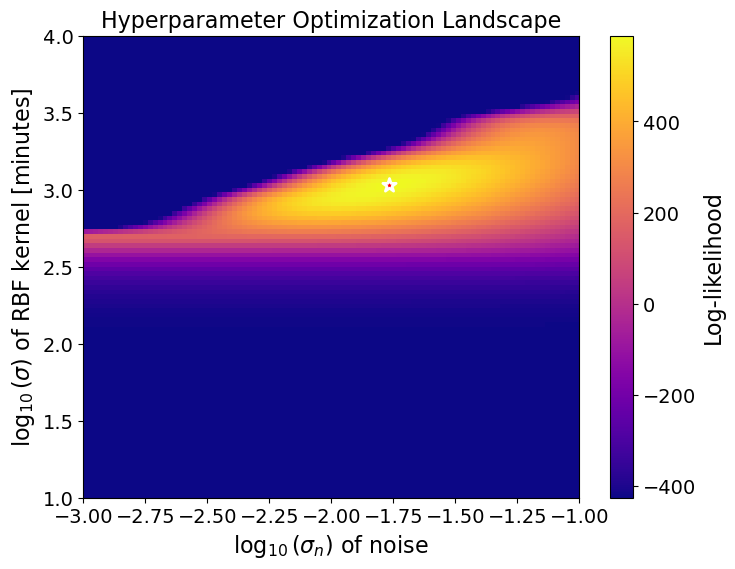

Optimal σ for RBF kernel: 1072.3 minutes
Optimal σ_n for noise: 0.017


In [15]:
# Plot the log-likelihood landscape
fig, ax = plt.subplots(figsize=(8, 6))

# Use percentile-based color limits for better contrast
vmin = np.percentile(logliks, 30)
vmax = np.percentile(logliks, 100)

im = ax.imshow(logliks, origin="lower", aspect="auto", cmap="plasma", 
               extent=[log_std_range[0], log_std_range[-1], log_sigma_range[0], log_sigma_range[-1]],
               vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Log-likelihood')

# Find and mark the best hyperparameters
best_idx = np.argmax(logliks)
best_i, best_j = np.unravel_index(best_idx, logliks.shape)
ax.scatter([log_std_range[best_j]], [log_sigma_range[best_i]], 
           color="red", s=100, marker='*', edgecolor='white', linewidth=2)

ax.set_xlabel("$\log_{10}(\sigma_n)$ of noise")
ax.set_ylabel("$\log_{10}(\sigma)$ of RBF kernel [minutes]")
ax.set_title('Hyperparameter Optimization Landscape')
plt.show()

# Extract the best hyperparameters
best_sigma = sigma_range[best_i]
best_std = 10**log_std_range[best_j]
print(f"Optimal σ for RBF kernel: {best_sigma:.1f} minutes")
print(f"Optimal σ_n for noise: {best_std:.3f}")

## Validating the Gaussian Process Model

Having determined the optimal hyperparameters through marginal likelihood maximization, we now validate our GP model by examining its predictive capabilities. The optimal length scale of ~1050 minutes (approximately 18 hours) aligns well with expected stellar oscillation timescales, while the inferred noise level of ~0.02 suggests relatively high-quality photometric data.

The GP provides two related predictive distributions. For the underlying noise-free function $f_*$:

$$p(f_*|t_*, \mathcal{D}) = \mathcal{N}(\mu_{f_*}, \sigma_{f_*}^2)$$

where:
- $\mu_{f_*} = \mathbf{k}_*^T(\mathbf{K} + \sigma_n^2\mathbf{I})^{-1}\mathbf{t}$
- $\sigma_{f_*}^2 = k(t_*, t_*) - \mathbf{k}_*^T(\mathbf{K} + \sigma_n^2\mathbf{I})^{-1}\mathbf{k}_*$

For future noisy observations $y_* = f_* + \epsilon_*$ where $\epsilon_* \sim \mathcal{N}(0, \sigma_n^2)$:

$$p(y_*|t_*, \mathcal{D}) = \mathcal{N}(\mu_{f_*}, \sigma_{f_*}^2 + \sigma_n^2)$$

The mean prediction remains the same (our best estimate of the underlying function), but the variance increases to account for observation noise. This distinction is important: we predict the smooth underlying stellar variability pattern but acknowledge that actual measurements will include noise. The uncertainty bands we plot represent this full predictive uncertainty for $y_*$, providing realistic confidence intervals for future observations.

In [16]:
def gp_reg(x_star, X, t, kernel, beta, **kernel_kwargs):
    """
    Perform Gaussian Process Regression to compute predictions.
    
    Parameters:
    -----------
    x_star : array
        Test input of shape (1, D)
    X : array
        Training inputs of shape (N, D)
    t : array
        Training targets of shape (N,)
    kernel : callable
        Kernel function
    beta : float
        Noise precision (1/sigma_n^2)
    kernel_kwargs : dict
        Additional kernel parameters
        
    Returns:
    --------
    mean : float
        Predictive mean of f_* (noise-free function)
    variance : float
        Predictive variance of y_* (including observation noise)
    """
    N, d = X.shape
    # Compute necessary kernel matrices
    K_X_X = kernel(X, X, **kernel_kwargs) + (1/beta) * np.eye(N) 
    K_x_star_X = kernel(x_star, X, **kernel_kwargs)
    K_x_star_x_star = kernel(x_star, x_star, **kernel_kwargs)
    
    # Use Cholesky decomposition for stable and efficient computation
    L = np.linalg.cholesky(K_X_X)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, t))
    
    # Calculate predicted mean (for f_*) and variance (for y_*)
    m_x_star = K_x_star_X @ alpha
    v = np.linalg.solve(L, K_x_star_X.T)
    variance_x_star = K_x_star_x_star - v.T @ v + (1/beta)  # Includes noise for y_*
    
    return m_x_star.flatten()[0], variance_x_star.flatten()[0]

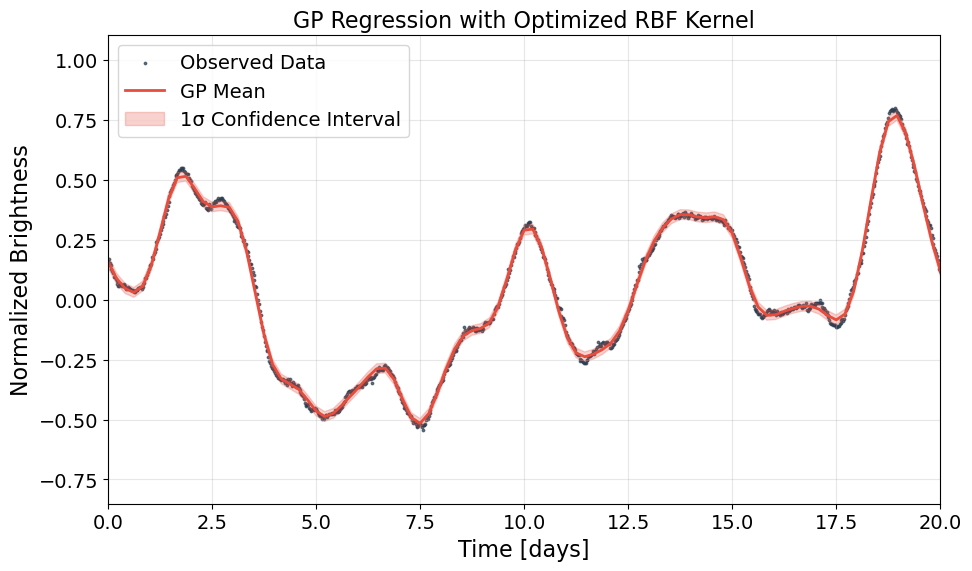

In [17]:
# Plot the GP regression results
fig, ax = plt.subplots(figsize=(10, 6))

# Plot observed data
ax.scatter(time/60/24, selected_light_curve, c="#2C3E50", s=3, label="Observed Data", alpha=0.7)

# Compute GP predictions at subsampled points
predictions = [gp_reg(t.reshape(-1, 1), t_sub[:,None], lc_sub, 
                     beta=1/best_std**2, kernel=rbf, sigma=best_sigma) 
               for t in t_sub]
predicted_means, predicted_vars = zip(*predictions)
predicted_stds = np.sqrt(predicted_vars)

# Plot the GP regression outcome
ax.plot(t_sub/60/24, predicted_means, color='#E74C3C', lw=2, label='GP Mean')
ax.fill_between(t_sub.flatten()/60/24,
                np.array(predicted_means) - np.array(predicted_stds),
                np.array(predicted_means) + np.array(predicted_stds),
                color='#E74C3C', alpha=0.25,
                label='1σ Confidence Interval')

# Plot aesthetics
ax.set_title("GP Regression with Optimized RBF Kernel")
ax.set_xlabel("Time [days]")
ax.set_ylabel("Normalized Brightness")
ax.legend(loc='upper left')
ax.set_xlim(0, 20)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The GP regression successfully captures the dominant oscillation pattern in the stellar light curve, with the learned timescale of approximately 18 hours corresponding to the quasi-periodic brightness variations. The narrow confidence intervals indicate high certainty in regions with dense observations, as expected from our conditioning formula.

However, notice that while the RBF kernel performs well at capturing the overall oscillatory behavior, it doesn't perfectly reproduce all the fine-scale features in the data. Some rapid variations and asymmetries in the oscillation pattern are smoothed over. This limitation stems from the RBF kernel's assumption of stationary, isotropic smoothness—it enforces the same characteristic timescale throughout the entire light curve. Real stellar oscillations often exhibit more complex behavior.

These observations suggest that while the simple RBF kernel provides a useful first-order characterization of stellar variability, more sophisticated kernels (such as quasi-periodic kernels or combinations of multiple kernels) might be needed for detailed asteroseismic analysis. Nevertheless, for our goal of extracting a characteristic timescale to correlate with stellar parameters, the RBF kernel proves entirely adequate.

## Scaling to Multiple Light Curves

Having validated our GP approach on a single light curve, we now face the challenge of applying this methodology to our entire dataset of 100 stars. This scaling presents both computational and methodological considerations that require careful attention.

The computational complexity of GP regression scales as $\mathcal{O}(N^3)$, where $N$ is the number of data points. For our full light curves with thousands of observations, this becomes prohibitive. Moreover, each star may have different optimal hyperparameters, requiring separate optimization procedures.

We address these challenges through several strategies:

1. **Strategic Subsampling**: We observed that the longest oscillation period in our dataset is approximately 3000 minutes. By analyzing only the first 1000 data points (approximately 20 days), we capture multiple oscillation cycles while significantly reducing computational cost.

2. **Two-Stage Optimization**: We first perform a coarse grid search over the length scale parameter only, holding the noise level fixed at a reasonable initial guess. This provides a robust initialization for the more sensitive length scale parameter, which has the greatest impact on the likelihood. We then refine both parameters jointly using gradient-based optimization.


In [18]:
from scipy.optimize import minimize

# Considering the longest oscillation period observed is around 3000 minutes, 
# we'll subsample the first 1000 data points which should provide a representative sample
t_sub = time[:1000]

# We start with an initial noise level guess
log_std_initial = np.log10(0.01)

# Set up a coarse grid search range for sigma
log_sigma_range = np.linspace(0, 4, 9)  # Coarse grid from 1 to 10^4 minutes
sigma_range = 10**log_sigma_range

# Define a function to compute the negative log-likelihood for optimization
def combined_negative_log_likelihood(params, t, lc, kernel):
    """
    Negative log-likelihood for scipy optimization.
    
    Parameters:
    -----------
    params : array
        [log10(sigma), log10(std)] parameters
    t : array
        Time points
    lc : array
        Light curve values
    kernel : callable
        Kernel function
        
    Returns:
    --------
    neg_log_lik : float
        Negative log-likelihood
    """
    log_sigma, log_std = params
    sigma = 10.**log_sigma
    beta = 1./(10**log_std)**2
    return -log_likelihood(t, lc, kernel, beta, sigma=sigma)

In [19]:
best_params = []  # To store the optimal values for sigma and noise level for each light curve

# Loop over all light curves
for lc in tqdm(light_curve, desc="Processing light curves"):
    lc_sub = lc[:1000]
    
    # Begin with a grid search to find a good starting point
    max_loglik = -np.inf
    best_grid_sigma = None
    
    for sigma in sigma_range:
        curr_loglik = log_likelihood(t_sub[:, None], lc_sub, rbf, 
                                    1/(10**log_std_initial)**2, sigma=sigma)
        if curr_loglik > max_loglik:
            max_loglik = curr_loglik
            best_grid_sigma = sigma
    
    # Use the grid search result as initial guess for optimization
    initial_guess = [np.log10(best_grid_sigma), log_std_initial]
    
    # Perform gradient-based optimization
    result = minimize(
        combined_negative_log_likelihood, 
        initial_guess, 
        args=(t_sub[:, None], lc_sub, rbf), 
        bounds=[(0, 4), (-2.5, np.log10(0.05))],  # Set bounds based on prior knowledge
        method='L-BFGS-B'
    )
    best_log_sigma, best_log_std = result.x
    best_params.append((10.**best_log_sigma, 10**best_log_std))

# Extract optimal parameters
best_sigmas, best_stds = zip(*best_params)

Processing light curves: 100%|██████████| 100/100 [10:20<00:00,  6.21s/it]


With optimal hyperparameters determined for each star in our sample, we can now examine how these GP-derived timescales relate to the fundamental stellar parameter of surface gravity. This analysis reveals whether our non-parametric approach successfully captures the physical relationship between stellar structure and oscillation properties.

The RBF length scale $\sigma$ learned by our GP represents the characteristic timescale over which stellar brightness varies smoothly. For stars exhibiting quasi-periodic oscillations, this parameter should correlate with the dominant oscillation period. Similarly, the inferred noise level $\sigma_n$ may reveal systematic trends related to stellar properties or observational characteristics.

By examining these relationships across our sample of 100 stars spanning a range of evolutionary states, we can assess whether GP regression provides physically meaningful characterizations of stellar variability:

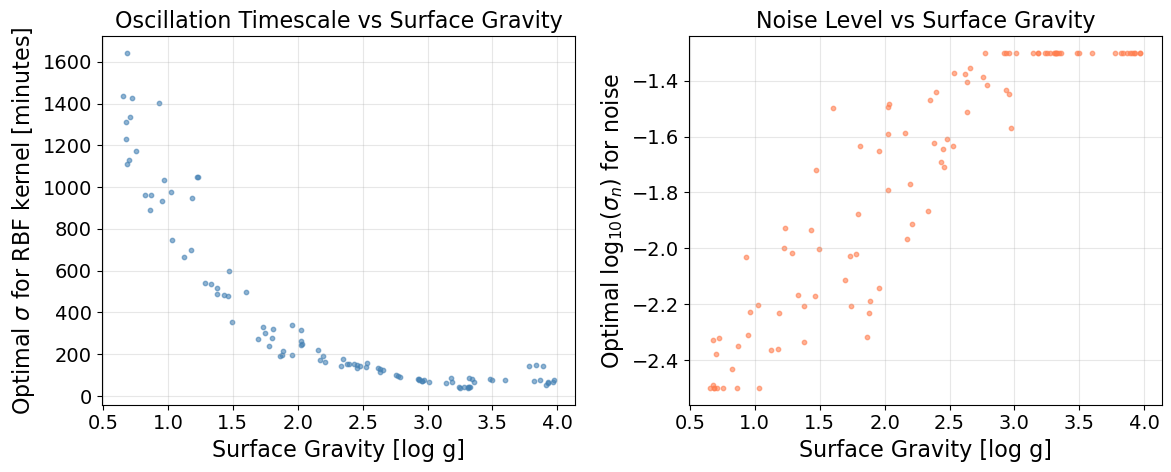

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot relationship between surface gravity and RBF timescale
ax1.scatter(label, best_sigmas, s=10, alpha=0.6, color='steelblue')
ax1.set_xlabel("Surface Gravity [log g]")
ax1.set_ylabel("Optimal $\sigma$ for RBF kernel [minutes]")
ax1.set_title("Oscillation Timescale vs Surface Gravity")
ax1.grid(True, alpha=0.3)

# Plot relationship between surface gravity and noise level
ax2.scatter(label, np.log10(best_stds), s=10, alpha=0.6, color='coral')
ax2.set_xlabel("Surface Gravity [log g]")
ax2.set_ylabel("Optimal log$_{10}(\sigma_n)$ for noise")
ax2.set_title("Noise Level vs Surface Gravity")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The analysis reveals physical relationships encoded in our GP hyperparameters. The left panel demonstrates a clear inverse correlation between surface gravity and oscillation timescale: as surface gravity increases (corresponding to more compact stars), the characteristic timescale decreases. This relationship aligns perfectly with asteroseismic theory—smaller stars have shorter acoustic travel times, leading to higher-frequency oscillations.

Notably, for stars with the highest surface gravities (log g > 4), we observe a clustering of timescales around 30 minutes. This value corresponds to our data's sampling interval, suggesting we've reached the resolution limit of our analysis. The RBF kernel, with its single characteristic timescale, cannot adequately capture oscillations occurring faster than the Nyquist frequency. This limitation highlights an important consideration when applying GPs to time series data: the kernel choice must be appropriate for the physical phenomena and sampling characteristics.

The right panel reveals systematic trends in the inferred noise levels. Lower surface gravity stars (giants) show consistently lower noise levels than their higher surface gravity counterparts (dwarfs). This pattern reflects observational realities: giant stars are intrinsically more luminous, leading to higher signal-to-noise ratios in photometric observations. In our analysis, we treated the noise level as an unknown parameter to be learned jointly with the oscillation timescale. However, in many practical applications, the noise characteristics might be well-determined from instrument calibration, photon statistics, or detector properties. In such cases, fixing $\sigma_n$ to its known value would reduce the optimization to a single parameter, potentially providing more stable and accurate estimates of the physically interesting oscillation timescales.

The pile-up of noise values at the upper boundary for high surface gravity stars signals a breakdown of our simple noise model—when oscillation timescales approach the sampling interval, the GP struggles to distinguish between rapid oscillations and observation noise. These results demonstrate that GP regression not only provides flexible function approximation but also yields physically interpretable parameters that encode meaningful information about the underlying system.

## Summary

This tutorial demonstrated how Gaussian Process regression provides a principled framework for analyzing stellar light curves and extracting astrophysical parameters. We developed intuition through pedagogical examples—from 2D Gaussian distributions to 1D function regression—before tackling the complexity of real astronomical data.

Key insights from our analysis:

1. **Hyperparameter Optimization**: The marginal likelihood provides a principled objective for learning kernel parameters, automatically balancing model complexity against data fit.

2. **Physical Interpretability**: The RBF length scale directly captures stellar oscillation timescales, revealing the inverse relationship between surface gravity and oscillation period predicted by asteroseismic theory.

3. **Joint Noise Modeling**: GP regression simultaneously learns signal and noise characteristics, with inferred noise levels reflecting the higher photometric precision achievable for luminous giant stars.

4. **Computational Considerations**: Strategic subsampling and two-stage optimization enable scaling to multiple light curves while managing the $\mathcal{O}(N^3)$ complexity of GP inference.

5. **Kernel Limitations**: When oscillation timescales approach the sampling interval, the simple RBF kernel reaches its limits—a reminder that kernel selection must match both physical phenomena and observational constraints.

These results extend beyond stellar astronomy. The same principles apply to any time series where we seek to characterize stochastic variability: quasar light curves, exoplanet transits, or gravitational wave signals. By encoding our expectations through kernel functions rather than explicit models, Gaussian Processes provide flexible yet interpretable analysis tools for modern astronomical surveys.